In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Github/Biometric

Mounted at /content/drive
/content/drive/My Drive/Github/Biometric


In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import cv2
from PIL import Image

from FUNC_script import *

In [3]:
# Load FaceNet Model
model = load_model('Template_poisoning/model/facenet_keras.h5', compile= False)
model.trainable= False

In [4]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

def Centroid(vector):
  '''
	  After the random initialization, we first optimize the
    glasses using the adversary’s centroid in feature space(Xc)
	 # Arguments
		Input: feature vector(batch_size x feature)	
	'''
  Xc= tf.math.reduce_mean(vector, axis=0)
  return tf.reshape(Xc, (1, vector.shape[-1]))

In [5]:
# Data  Loading
def load_data(dir):
  X=[]
  for i, sample in enumerate(os.listdir(dir)):
    image= load_img(os.path.join(dir, sample))
    image = cv2.resize(image, (160, 160))
    X.append(image/255.0)
  return np.array(X)

X= load_data('Template_poisoning/Croped_data/adversary_images')
Target_samples= load_data('Template_poisoning/Croped_data/target_images')
X_ex= X.copy() # Copy of X
print('Adversarial Batch:',X.shape)

Adversarial Batch: (24, 160, 160, 3)


In [6]:
# GET Mask
mask= load_img('Template_poisoning/final_mask.png') #Sacle(0-255), RGB
mask= mask/255.0
mask.shape

(160, 160, 3)

In [8]:
# img_tr= load_img('Template_poisoning/Croped_data/target_images/ben_afflek_0.jpg')
# feature_tr= model.predict(img_tr[np.newaxis, :, :, :])
#Target= Generate_target(feature_tr, batch_size= X.shape[0])

Target= Centroid(model.predict(Target_samples))
Target= Generate_target(Target, batch_size= X.shape[0])
Target.shape

(24, 128)

In [9]:
delta_x= np.random.uniform(low=0.0, high=1.0, size=X.shape) # Scale(0-1)
delta_x.shape

(24, 160, 160, 3)

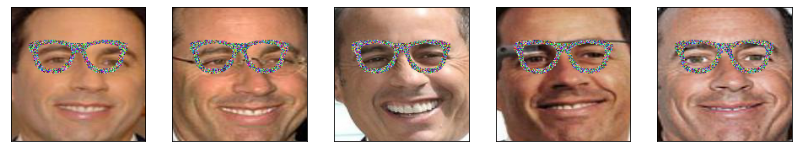

In [10]:
f, ax= plt.subplots(1, 5, figsize=(14, 4))
image= X*(1-mask)+ delta_x*mask
for i in range(5):
  ax[i].imshow(image[i+5])
  ax[i].set_xticks([]); ax[i].set_yticks([])
plt.show()
del image

In [11]:
Xc= Centroid(model.predict(X)) #(1 x 128)
print(Xc.shape)
Xc= Generate_target(Xc, batch_size=24) #(24 x 128)
print(Xc.shape)

(1, 128)
(24, 128)


In [19]:
def loss_object(pred, label, delta= delta_x, direction= False):
  # Loss= euclidean distance + Delta_x pixel Variance
  dist= Euclidean_dist(pred, label)
  variance= Sample_variance(delta_x)
  if direction:
    sc= tf.math.subtract(1.0, tf.math.divide(1.0, label.shape[0]))

    vector_mean= tf.math.multiply(dist, sc)
   
    target_dir= tf.math.multiply(vector_mean, dist)
    Loss= tf.math.add(target_dir, tf.cast(variance, dist.dtype))
    return Loss

  Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
  return Loss

In [13]:
def back_propagate(model, X, mask, delta_x, label, direction= False):
  with tf.GradientTape() as g:
      g.watch(delta_x)
      X_batch= Generate_sample(X, delta_x, mask)
      feature= model(X_batch)
      loss= loss_object(pred= feature, label= label, delta= delta_x, direction= direction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = g.gradient(loss, delta_x)
  return gradient, tf.reduce_mean(loss).numpy()

In [14]:
# Tf Variables
X= tf.Variable(X, dtype=tf.float64)
delta_x= tf.Variable(delta_x, dtype=tf.float64)
mask= tf.Variable(mask, dtype=tf.float64)
Xc= tf.Variable(Xc)

In [18]:
# epoch= 151
# Lambda= 0.5
# for ep  in range(epoch):
#   grad, loss= back_propagate(model, X, mask, delta_x, Xc)
#   # Gradient step
#   delta_x= delta_x - Lambda*grad
#   if ep%10 == 0:
#     print('Epoch: {}  Loss: {:.3f}'.format((ep+1), loss))

In [20]:
Lambda= 0.4
for ep  in range(int(1.5*epoch)):
  grad, loss= back_propagate(model, X, mask, delta_x, Target, direction= True)
  # Gradient step
  delta_x= delta_x - Lambda*grad
  if ep== 100:
    delta_x1= tf.identity(delta_x)
  elif ep== 170:
    Lambda= 0.2
    delta_x2= tf.identity(delta_x)
  if ep%10 == 0:
    print('Epoch: {}, Loss: {}'.format((ep+1), loss))

Epoch: 1, Loss: 294.4563293457031
Epoch: 11, Loss: 202.10227966308594
Epoch: 21, Loss: 170.43922424316406
Epoch: 31, Loss: 148.87106323242188
Epoch: 41, Loss: 129.5446319580078
Epoch: 51, Loss: 113.48641204833984
Epoch: 61, Loss: 100.25741577148438
Epoch: 71, Loss: 88.8901596069336
Epoch: 81, Loss: 82.15789031982422
Epoch: 91, Loss: 75.33998107910156
Epoch: 101, Loss: 70.4145278930664
Epoch: 111, Loss: 66.873779296875
Epoch: 121, Loss: 65.7633056640625
Epoch: 131, Loss: 62.51997756958008
Epoch: 141, Loss: 62.06959533691406
Epoch: 151, Loss: 63.006229400634766
Epoch: 161, Loss: 57.780609130859375
Epoch: 171, Loss: 59.750640869140625
Epoch: 181, Loss: 57.18751907348633
Epoch: 191, Loss: 57.5963134765625
Epoch: 201, Loss: 55.03996276855469
Epoch: 211, Loss: 54.75507736206055
Epoch: 221, Loss: 54.685333251953125


In [21]:
adv_sample=Generate_sample(X, delta_x, mask)
adv_sample=adv_sample.numpy()
adv_sample.shape

(24, 160, 160, 3)

In [22]:
adv_sample=np.clip(adv_sample, 0, 1)

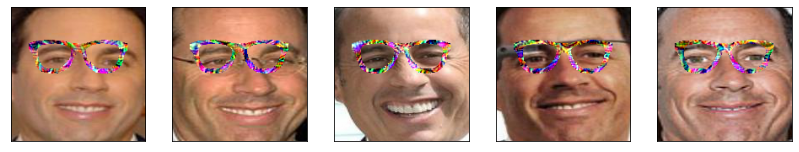

In [23]:
f, ax= plt.subplots(1, 5, figsize=(14, 4))
for i in range(5):
  ax[i].imshow(adv_sample[i+5])
  ax[i].set_xticks([]); ax[i].set_yticks([])
plt.show()

In [24]:
adv_feature= model.predict(X_ex)
df_adv= pd.DataFrame(adv_feature)

In [25]:
adv_modified_feature= model.predict(adv_sample)
df_adv_modify= pd.DataFrame(adv_modified_feature)

In [26]:
target_feature= model.predict(Target_samples)
df_target= pd.DataFrame(target_feature)

In [27]:
df_adv['target']= 'Adversarial_sample'
df_adv_modify['target']= 'Adversarial_sample_with_Pubertation'
df_target['target']= 'Target_sample'

df=pd.concat([df_target, df_adv_modify, df_adv], ignore_index= True)
df.shape

(61, 129)

In [28]:
pca = PCA(n_components=2) 
# Fit pca to 'X'
df1= pd.DataFrame(pca.fit_transform(df.drop(['target'], 1)))
df1.shape

(61, 2)

In [29]:
df1['target']= df.target

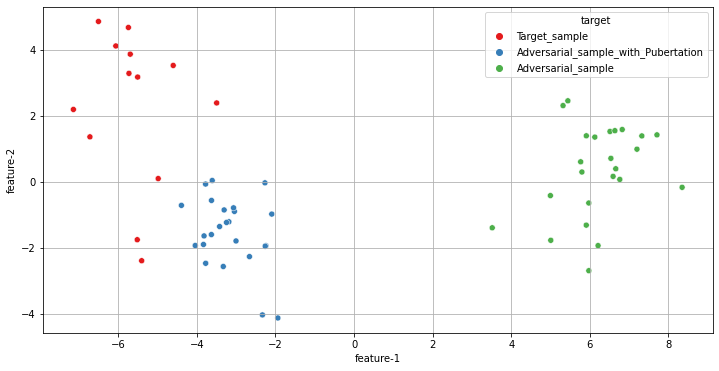

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(True)
plt.xlabel('feature-1'); plt.ylabel('feature-2')
sns.scatterplot(x=df1.iloc[:, 0] , y= df1.iloc[:, 1], hue = df1.iloc[:, 2], data= df1, palette='Set1', ax= ax)
plt.show()